##Setting

In [ ]:
!git clone https://github.com/openaifab/suicide_multiclass.git
#!pip install ckiptagger

Cloning into 'suicide_multiclass'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 36 (delta 3), reused 0 (delta 0), pack-reused 22
Unpacking objects: 100% (36/36), done.


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/ai_data_colab2/mingliu.ttc \
    -O suicide_multiclass/mingliu.ttc
#word embedding
!wget --no-check-certificate \
    https://storage.googleapis.com/ai_data_colab2/cna.cbow.512d.0.txt \
    -O suicide_multiclass/word2vec_model/cna.cbow.512d.0.txt

--2020-07-10 05:11:40--  https://storage.googleapis.com/ai_data_colab2/mingliu.ttc
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32217124 (31M) [application/octet-stream]
Saving to: ‘suicide_multiclass/mingliu.ttc’

suicide_multiclass/ 100%[===================>]  30.72M  37.2MB/s    in 0.8s    

2020-07-10 05:11:42 (37.2 MB/s) - ‘suicide_multiclass/mingliu.ttc’ saved [32217124/32217124]

--2020-07-10 05:11:44--  https://storage.googleapis.com/ai_data_colab2/cna.cbow.512d.0.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 108.177.96.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 772655316 (737M) [text/plain]
Sav

In [ ]:
#%tensorflow_version 1.X
import tensorflow as tf
print(tf.__version__)

2.2.0


In [ ]:
%cd suicide_multiclass
%pwd

/content/suicide_multiclass


'/content/suicide_multiclass'

#Data preprocess

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import pickle
from gensim.models import word2vec
import logging
import random

In [ ]:
from OpenFabLibrary import JeibaCutWords
#from OpenFabLibrary import AppendKeywordCheck
from OpenFabLibrary import process_df

##Set parameters

In [ ]:
# HIGH_RISK = 2
# MEDIUM_RISK = 1
# NO_RISK = 0

data_dir = "/".join((".", "data"))
#用記事本打開csv文件，另存為设置編碼為utf-8
data_source = "suicide3_train.csv"

##Load training set data

In [ ]:
data_df = pd.read_csv(data_dir + '/' + data_source, encoding='utf8', delimiter=',')
print(data_df.head())

   ID                                        Description  Class
0   0  最近又把自己蜷縮起來了不想吃不想動好想消失...沒有社會化的我連狗狗都有點社會化不足都兩歲了...      2
1   1  我想已經沒有意義了活著的動力每一天每一天不論在做什麼不論做的好壞一律歸零一切都是爛我整個人生...      2
2   2  因為身心狀況的關係把論文停掉 打算延畢除了指導老師  其他朋友我都沒說昨晚笑笑地跟室友說我買...      2
3   3  可能因為去年流了太多眼淚，又一直失眠拼命讓自己很忙很累才能閉上眼睡著眼睛很少休息所以左眼出了...      2
4   4  到底為什麼週日總會失眠？明明週一要早起為了這個嶄新的開始我最喜歡的禮拜一也應該早睡的可是就是...      2


##斷詞斷句

In [ ]:
# 斷詞處理
train_data_df = JeibaCutWords(data_df, "Description")

# word count
sentence_data = train_data_df.loc[:,'sentence']
train_data_df['word_count'] = sentence_data.str.len() 

print(train_data_df.head())

Building prefix dict from /content/suicide_multiclass/Jeiba/dict.txt.big ...
Dumping model to file cache /tmp/jieba.ucb66ba17c4739edbeb5fb122bb3a9bb9.cache
Loading model cost 1.296 seconds.
Prefix dict has been built successfully.


   id                                           sentence  class  word_count
0   0  [最近, 蜷縮, 縮起, 縮起來, 動, 消失, 社會, 社會化, 狗狗, 有點, 社會, ...      2          93
1   1  [有意, 意義, 動力, 好壞, 歸零, 一切都是, 爛, 整個, 人生, 最差, 一次, ...      2          39
2   2  [身心, 狀況, 關係, 論文, 停掉,  , 打算, 延, 畢, 指導, 指導老師, 老師...      2          58
3   3  [去年, 流, 太多, 多眼, 眼淚, 失眠, 拼命, 很忙, 累, 閉上眼, 上眼, 睡,...      2          28
4   4  [總會, 失眠, 明明, 一要, 早起, 嶄新, 最, 禮拜, 應該, 早睡, 睡, 感冒,...      2         144


In [ ]:
#Check if there is empty data
for i in range(len(train_data_df)):
  if len(train_data_df.loc[i,'sentence']) < 3:
    print(i, ":", train_data_df.loc[i,'sentence'])

斷詞後文章長度: 


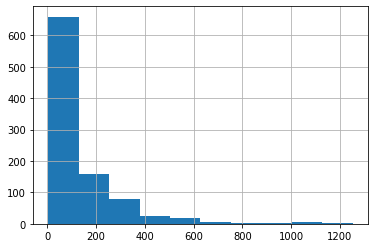

In [ ]:
print("斷詞後文章長度: ")
train_data_df['word_count'].hist()

各風險則數: 
高風險: 121 則
中風險: 181 則
低風險: 657 則
總共: 959 則


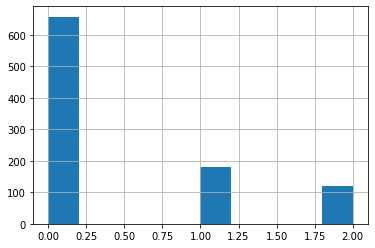

In [ ]:
print("各風險則數: ")
train_data_df['class'].hist()

print(f"高風險: {data_df[data_df['Class'] == 2].shape[0]} 則") 
print(f"中風險: {data_df[data_df['Class'] == 1].shape[0]} 則") 
print(f"低風險: {data_df[data_df['Class'] == 0].shape[0]} 則")
print(f"總共: {data_df.shape[0]} 則")

##關鍵字檢查

In [ ]:
# 關鍵字檢查
# train_data_df['keyword_flag'], _ = AppendKeywordCheck(train_data_df)
# print(train_data_df.head(5))

# 儲存為pickle格式檔案
with open(data_dir + '/' + 'train_tokenized', 'wb') as file:
    pickle.dump(train_data_df, file)

##製作文字雲

   id                                           sentence  class  word_count
0   0  [最近, 蜷縮, 縮起, 縮起來, 動, 消失, 社會, 社會化, 狗狗, 有點, 社會, ...      2          93
1   1  [有意, 意義, 動力, 好壞, 歸零, 一切都是, 爛, 整個, 人生, 最差, 一次, ...      2          39
2   2  [身心, 狀況, 關係, 論文, 停掉,  , 打算, 延, 畢, 指導, 指導老師, 老師...      2          58
3   3  [去年, 流, 太多, 多眼, 眼淚, 失眠, 拼命, 很忙, 累, 閉上眼, 上眼, 睡,...      2          28
4   4  [總會, 失眠, 明明, 一要, 早起, 嶄新, 最, 禮拜, 應該, 早睡, 睡, 感冒,...      2         144
低風險文字雲:


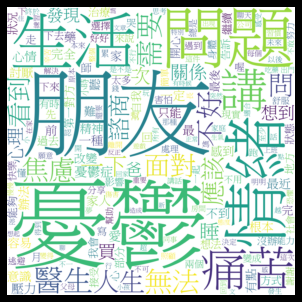

中風險文字雲:


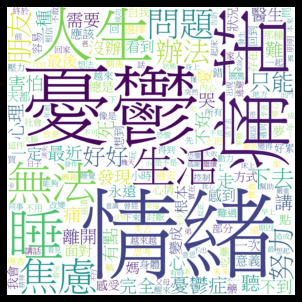

高風險文字雲:


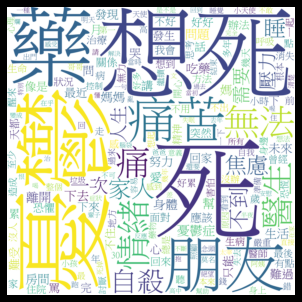

In [ ]:
from OpenFabLibrary import ShowWordCloud

with open(data_dir + '/' + 'train_tokenized', 'rb') as file:
    train_tokenized_df = pickle.load(file)
print(train_tokenized_df.head())
ShowWordCloud(train_tokenized_df)

##Save the processed data

In [ ]:
with open(data_dir + '/' + 'train_tokenized', 'rb') as file:
    train_tokenized_df = pickle.load(file)

corpus_source = train_tokenized_df['sentence']
print(corpus_source)

0      [最近, 蜷縮, 縮起, 縮起來, 動, 消失, 社會, 社會化, 狗狗, 有點, 社會, ...
1      [有意, 意義, 動力, 好壞, 歸零, 一切都是, 爛, 整個, 人生, 最差, 一次, ...
2      [身心, 狀況, 關係, 論文, 停掉,  , 打算, 延, 畢, 指導, 指導老師, 老師...
3      [去年, 流, 太多, 多眼, 眼淚, 失眠, 拼命, 很忙, 累, 閉上眼, 上眼, 睡,...
4      [總會, 失眠, 明明, 一要, 早起, 嶄新, 最, 禮拜, 應該, 早睡, 睡, 感冒,...
                             ...                        
954    [念頭, 淹沒, 腦袋, 確實, 影響, 行動, 動力, 其他同學, 同學, 相比, 寫, ...
955    [有點, 察覺, 是因爲, 因爲, 壓力, 大社, 社交, 網路, 太久, 幾天, 密集, ...
956    [列表, 想當然, 只能, 保全, 方面, 看來看去, 看去, 求,  ,  ,  ,  ,...
957    [明年, 生, 找到, 房子, 看到, 一間, 房, 廳, 萬塊, 問, 一堆, 問題,  ...
958    [平安, 平安夜, 幹嘛, 剛去, 熱, 紅酒, 料,  , 殘念, 第二, 第二家, 二家...
Name: sentence, Length: 959, dtype: object


##設定Word2Vec參數並訓練詞向量

In [ ]:
WORD2VEC_DIMENTION = 128
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')
logging.root.setLevel(level=logging.INFO)

def TrainWord2VecModel(input_corpus):
    # build word2vec
    # sg=0 CBOW ; sg=1 skip-gram
    model = word2vec.Word2Vec(size=WORD2VEC_DIMENTION, min_count=5, window=5, sg=0)

    # build vocabulary
    model.build_vocab(input_corpus)

    # train word2vec model ; shuffle data every epoch
    for i in range(40):
        print("%d-th training" % (i))
        random.shuffle(input_corpus)
        model.train(input_corpus, total_examples=len(input_corpus), epochs=1)

    ## save model
    model.save('word2vec_model/CBOW')

In [ ]:
# 若要用已經訓練好的詞向量，這一步可以不做
# 若要訓練新的詞向量，把註解拿掉
# 現階段使用pre-trained mode zh, 300d, 50101 words
TrainWord2VecModel(corpus_source)

In [ ]:
w2v = word2vec.Word2Vec.load('word2vec_model/CBOW')  # 載入剛剛訓練好的Word2Vec model

test_word = '想死'

print(f"'{test_word}'字詞相似度: ")
#print(w2v.wv[test_word])
w2v.wv.most_similar(test_word)

2020-07-09 05:47:01,294: INFO: loading Word2Vec object from word2vec_model/CBOW
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-07-09 05:47:01,336: INFO: loading wv recursively from word2vec_model/CBOW.wv.* with mmap=None
2020-07-09 05:47:01,337: INFO: setting ignored attribute vectors_norm to None
2020-07-09 05:47:01,338: INFO: loading vocabulary recursively from word2vec_model/CBOW.vocabulary.* with mmap=None
2020-07-09 05:47:01,340: INFO: loading trainables recursively from word2vec_model/CBOW.trainables.* with mmap=None
2020-07-09 05:47:01,343: INFO: setting ignored attribute cum_table to None
2020-07-09 05:47:01,345: INFO: loaded word2vec_model/CBOW
2020-07-09 05:47:01,358: I

'想死'字詞相似度: 


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('死掉', 0.7651195526123047),
 ('願望', 0.6770889163017273),
 ('該死', 0.6549395322799683),
 ('鏡', 0.6224474906921387),
 ('看不起', 0.6147435903549194),
 ('念頭', 0.6017012596130371),
 ('不是故意', 0.5947930812835693),
 ('疼', 0.5865309834480286),
 ('五月', 0.5849170088768005),
 ('地獄', 0.5789046287536621)]

In [ ]:
# 列印出訓練好的詞向量
print("詞向量維度:", w2v.wv.vectors.shape)
fo = open("./word2vec.txt", "w+")
for index, vector in enumerate(w2v.wv.vectors):
    #print(vector)
    fo.write(str(vector))
fo.close()

詞向量維度: (4172, 128)


#Train model

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from gensim.models import word2vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from OpenFabLibrary import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
train_data_source = 'train_tokenized'

trunc_type='post'
padding_type='pre' #'pre'
oov_tok = "<OOV>"
#vocab_size = 50000
max_length = 500 # 選取多少詞來當作輸入 Ex:選前面40個詞當作輸入

VALIDATION_RATIO = 0.1

WORD2VEC_DIMENTION = 512 #512 300 128 100

##Load dataset

In [ ]:
# load article tokenized
with open(data_dir + "/" + train_data_source, 'rb') as file:
    article_df = pickle.load(file)

print(article_df.head(5))

print("#"*100)
print(f"高風險: {article_df[article_df['class'] == 2].shape[0]} 則") 
print(f"中風險: {article_df[article_df['class'] == 1].shape[0]} 則") 
print(f"低風險: {article_df[article_df['class'] == 0].shape[0]} 則")
print(f"總共: {article_df.shape[0]} 則")

   id                                           sentence  class  word_count
0   0  [最近, 蜷縮, 縮起, 縮起來, 動, 消失, 社會, 社會化, 狗狗, 有點, 社會, ...      2          93
1   1  [有意, 意義, 動力, 好壞, 歸零, 一切都是, 爛, 整個, 人生, 最差, 一次, ...      2          39
2   2  [身心, 狀況, 關係, 論文, 停掉,  , 打算, 延, 畢, 指導, 指導老師, 老師...      2          58
3   3  [去年, 流, 太多, 多眼, 眼淚, 失眠, 拼命, 很忙, 累, 閉上眼, 上眼, 睡,...      2          28
4   4  [總會, 失眠, 明明, 一要, 早起, 嶄新, 最, 禮拜, 應該, 早睡, 睡, 感冒,...      2         144
####################################################################################################
高風險: 121 則
中風險: 181 則
低風險: 657 則
總共: 959 則


In [ ]:
#turn sentence and label into [['甲 乙 丙 丁', label], [,]....]
corpus = process_df(article_df)
print(f"total cases: {len(corpus)}")
print(corpus)

##Split into training and validation dataset

In [ ]:
sentences_train=[]
labels_train=[]

random.seed(30)
random.shuffle(corpus)

training_size = int(len(corpus) * (1-VALIDATION_RATIO))

for x in range(training_size):
    sentences_train.append(corpus[x][0])
    labels_train.append(corpus[x][1])

tokenizer = Tokenizer(oov_token=oov_tok) #num_words = vocab_size
tokenizer.fit_on_texts(sentences_train)

print(f"training data: {len(sentences_train)}")

print(sentences_train[:10])
print(labels_train[:10])

training data: 863
['下課 休息 老師 進行 一整 整個 學期 分組 一組 形式 坐在 同一 一張 桌子 上進 進行 課堂 討論 論到 學期 學期末 期末 年齡 五十 五十幾 五十幾歲 十幾 十幾歲 幾歲 博 班 大叔 坐 同一 一張 桌子 原本 應該 自然 大叔 兩 一組 下課 下課時 下課時間 課時 交流 流時 發現 踩到 地雷 腦筋 靈活 類型 尤其 班上 同學 來自 同學 學科 背景 當初 初選 門 課 目的 角度 刺激 思考 環境 下學 學習 大叔 有產 產業 業經 經驗 思想 僵化 固執 缺乏 彈性 訊息 交流 緩慢 聊 十分 十分鐘 分鐘 不到 凍 未 條 一整 整個 學期 同組 實在 折磨 所謂 個性 不合 已 萌生 撇下 加入 剩下 兩個 組 想法 擔心 老人 感到 拋下 而有 有所 顧慮 選 兩個 組 意味 意味著 地雷 拋 加入 組 眼看 休息 休息時間 結束 有時 私心 良心 掙扎 老師 説 一組 提醒 當初 初選 門 課 初衷 無視 大叔 似乎 瓦解 意願 組 藉口 瞎 )， 迅速 兩個 組 打過 過招 招呼 果斷 要求 求和 大叔 split 加入 別組 推給 。============================================= 外人 人眼 歧視 老人 原本 保持 友善 開放 態度 對方 聊聊 我會 選擇 推給 全 無能 能力 大叔 相處 維持 進度 程度 能幹 回想 我會 感到 同組 壓力 關係 感到 不明 明確 同一 一門 課 同學 確定 同輩 長輩 同輩 長輩 相處 模式 不一 組 組 應該 鬆 一口 一口氣 口氣 總 勉強 強拆 拆開 分好 組 自行 自行決定 決定 瓦解 組別 説 大叔 相處 ?)。 當初 交談 時果 果斷 拿到 主導 主導權 主動 關係 定義 平輩 講 經驗 告訴 階級 感 重 不自 不自在 自在 。============================================= 自以 順利 融入 新 組別 老人 皮球 踢 有罪 罪惡 罪惡感 惡感 總覺 大叔 新 組員 轉頭 投以 你好 狡猾 眼神 做賊心虛 賊心 心虛 產生 錯覺 朋友 訴說 朋友 説 實在 夠 現實 聰明 迅速 反應 嚇一跳 早就 許多 陰暗 陰暗面 天才 意識 原來 耍 心機 手腕 缺

In [ ]:
sentences_val=[]
labels_val=[]
#validation_size = len(corpus) - training_size
for x in range(training_size, len(corpus)):
    sentences_val.append(corpus[x][0])
    labels_val.append(corpus[x][1])

print(f"validation data: {len(sentences_val)}")

print(sentences_val[:5])
print(labels_val[:5])

validation data: 96
['小時 小時候 霸 凌 在家 長期 虐待 上學 霸 凌 社會 社會工作 明明                 認真 不順 不順遂 順遂                 父親 幾十 幾十年 十年 喝醉 喝醉酒 醉酒 半夜 夜大 大吵 大吵大鬧 沒辦 辦法 睡覺 思 覺 失調                 忘掉 過去 心安 心安理得 理得 日子                 出生 以來 該死                 卯 一身 好好 書 還要 想起                 悲傷 回憶 出生 生在 世上                 幻聽 能力 大腦 內分 內分泌 分泌 失調                 大腦 受 器 連結 錯誤 思考 連結 錯誤 情況 出現                 想一想 人生 無奈 大半 人生 生就 浪費 掉 無力 抵抗                 只能 坐在 電腦 電腦前 人生 浪費 掉                 幻聽 聽會 房子 住 不用 繳 房租                 講起 像是 病 換來 人願 願意 大腦 壞掉                 換房 房子 住                 老實 實說 直覺 幻聽 冤親 債主 滿天 天神 神佛                 幫 想想 病情 幻聽 變                 少 神 只能 幫助 以其 只能 只能靠                 凡事 努力 總覺 努力 看不出 不出                 效果 灰心 失望                 未來 感 不到 到任 人生 得到 思 覺 失調 作 收場                 美好 事物 屬於                 即使如此 須要 來養 養活 算得 算得了 病                 生活 負責 病 同情 可憐 只好 縮起 縮起來                 生活 應付 實在 累                 本來 想去 跑步 但因 天氣 實在 太冷 有點 猶豫 跑                 步 洗澡 實在                 人生 好多 問題 面對 問題 難 痛苦       

##Check the tokenizer

In [ ]:
word_index = tokenizer.word_index
vocab_size = len(word_index)
index_word = tokenizer.index_word

print(f'vocab size is: {vocab_size}')
print(word_index)
#print(index_word[4786])

##Sentence to sequence transform

In [ ]:
sequences_train = tokenizer.texts_to_sequences(sentences_train)
padded_train = pad_sequences(sequences_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)

sequences_val = tokenizer.texts_to_sequences(sentences_val)
padded_val = pad_sequences(sequences_val, maxlen=max_length, padding=padding_type, truncating=trunc_type)

labels_train = np.array(labels_train)
labels_val = np.array(labels_val)

print(padded_val)
print(labels_val)

print("#"*100)
print("high risk train: ",np.sum(labels_train==2))
print("medium risk train: ",np.sum(labels_train==1))
print("low risk train: ",np.sum(labels_train==0))

print("high risk val: ",np.sum(labels_val==2))
print("medium risk val: ",np.sum(labels_val==1))
print("low risk val: ",np.sum(labels_val==0))

[[    0     0     0 ...   119   809  3427]
 [    0     0     0 ...  1444   180   817]
 [    0     0     0 ...   152 10413     1]
 ...
 [    0     0     0 ...     1   357  7870]
 [  209  1949  7248 ...     1  3370  6723]
 [    0     0     0 ...  8065  8066  8067]]
[1 0 2 0 2 2 1 0 2 0 0 1 0 0 0 1 0 0 2 0 0 1 0 0 2 0 0 2 0 1 0 0 0 1 1 1 0
 0 0 0 0 1 0 2 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 2 0 2 0 1 0 0 0 0 1 0 0 0 0 1
 2 2 0 1 2 0 1 1 0 0 0 2 0 0 0 0 0 2 0 0 0 1]
####################################################################################################
high risk train:  106
medium risk train:  159
low risk train:  598
high risk val:  15
medium risk val:  22
low risk val:  59


##Load pre-trained w2v, create word ID mapping and word vector

### Kevin

In [ ]:
#w2v = word2vec.Word2Vec.load('word2vec_model/CBOW')
w2v = word2vec.Word2Vec.load('word2vec_model/zh.bin')
word2id = {k:i for i, k in enumerate(w2v.wv.vocab.keys())}
id2word = {i:k for k, i in word2id.items()}
#print(word2id)
word2id_len = len(word2id)
print('word2id_len:', word2id_len)
print('the last word is:', id2word[word2id_len-1])

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


word2id_len: 50101
the last word is: 戰期間


In [ ]:
# print("詞向量維度:", w2v.wv.vectors.shape)
# test_word = '自殺'
# print(f"'{test_word}'字詞相似度: ")
# #print(w2v.wv[test_word])
# w2v.wv.most_similar(test_word)

In [ ]:
embeddings_matrix = np.zeros((vocab_size + 1, WORD2VEC_DIMENTION)) # +1 because index_word index starts from 1
for word, i in word_index.items():
  if word in word2id:
    embedding_vector = w2v.wv[word]
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

print(embeddings_matrix.shape)
print(embeddings_matrix)

(18418, 300)
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.2249358  -0.96961224  0.70858282 ... -0.19811729  0.16071561
  -0.15473877]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


### 科技大擂台
https://github.com/ysj-sp/jin-jin-ti-generator/blob/master/training.py  
https://fgc.stpi.narl.org.tw/activity/videoDetail/4b1141305ddf5522015de5479f4701b1

In [ ]:
# Get word vector
dim = 0
word_vecs = {}
with open('word2vec_model/cna.cbow.512d.0.txt') as f:
    for line in f:
        tokens = line.strip().split()

        if len(tokens) == 2:
            dim = int(tokens[1])
            continue

        word = tokens[0]
        vec = np.array([float(t) for t in tokens[1:]])
        word_vecs[word] = vec

In [ ]:
print("total words in the pre-trained w2v:", len(word_vecs))
print("dimension: ",len(word_vecs['想要']))
print(word_vecs.get('想死', None))

total words in the pre-trained w2v: 158566
dimension:  512
None


In [ ]:
embeddings_matrix = np.zeros((vocab_size + 1, WORD2VEC_DIMENTION)) # +1 because index_word index starts from 1
for word, i in word_index.items():
  if word in word_vecs:
    embedding_vector = word_vecs[word]
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

print(embeddings_matrix.shape)
print(embeddings_matrix)

(17897, 512)
[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [-0.293505  0.676929 -0.694333 ... -0.838017 -1.443087 -1.639135]
 ...
 [ 0.956706 -0.499619 -2.010002 ... -0.471632 -0.755814 -1.029145]
 [-0.429789  0.15046   0.872821 ...  1.281458 -1.557886  0.553418]
 [-0.158433 -0.28365   0.18321  ... -0.362449 -1.260941  0.763974]]


##Create LSTM model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, WORD2VEC_DIMENTION, input_length=max_length, weights=[embeddings_matrix], trainable=False), #trainable=False
    # tf.keras.layers.Embedding(vocab_size + 1, 16, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), # 64, 32
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),  #6, 8
    tf.keras.layers.Dense(3, activation='softmax') #3 softmax
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy']) #sparse_categorical_crossentropy
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 512)          9163264   
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 128)          295424    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 9,500,995
Trainable params: 337,731
Non-trainable params: 9,163,264
________________________________________

##Set callback and class_weight

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.96):
      print("\nReached 96% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, 
                                             verbose=1, mode='auto', restore_best_weights=True)

In [ ]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(labels_train), labels_train)
print(class_weights)

[0.48104794 1.80922432 2.71383648]


##Train the model

In [ ]:
BATCH_SIZE = 2
NUM_EPOCHS = 20

history = model.fit(padded_train, labels_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, 
                    validation_data=(padded_val, labels_val),callbacks=[earlystop]
                    , class_weight={0:class_weights[0], 1:class_weights[1], 2:class_weights[2]}) #, class_weight={0:class_weights[0], 1:class_weights[1], 2:class_weights[2]}
# Save the entire model as a SavedModel.
#model.save('model/suicide_model.h5')

Epoch 1/20
432/432 [==============================] - 25s 57ms/step - loss: 1.0810 - accuracy: 0.4450 - val_loss: 0.9674 - val_accuracy: 0.5625
Epoch 2/20
432/432 [==============================] - 24s 55ms/step - loss: 0.9650 - accuracy: 0.6269 - val_loss: 0.9152 - val_accuracy: 0.5938
Epoch 3/20
432/432 [==============================] - 23s 54ms/step - loss: 0.7122 - accuracy: 0.7694 - val_loss: 1.2001 - val_accuracy: 0.5729
Epoch 4/20
432/432 [==============================] - 23s 54ms/step - loss: 0.4636 - accuracy: 0.8575 - val_loss: 1.0509 - val_accuracy: 0.6562
Epoch 5/20
432/432 [==============================] - 23s 53ms/step - loss: 0.2697 - accuracy: 0.9154 - val_loss: 1.1526 - val_accuracy: 0.6250
Epoch 6/20
432/432 [==============================] - 23s 54ms/step - loss: 0.1499 - accuracy: 0.9560 - val_loss: 1.4272 - val_accuracy: 0.5625
Epoch 7/20
432/432 [==============================] - 23s 54ms/step - loss: 0.1251 - accuracy: 0.9548 - val_loss: 1.3853 - val_accuracy:

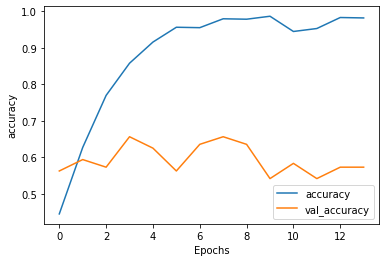

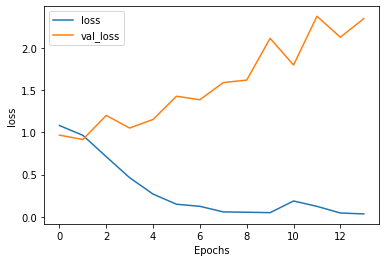

In [ ]:
%matplotlib inline

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

#See Validation Confusion Matrix

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
all predicted result: [0 0 0 0 0 2 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 2 2 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 2 0 0 0 0 0 1 0 0 0 2 0 0 0 0 0 0 0 0 0 1]
Confusion matrix, without normalization
[[53  4  2]
 [15  7  0]
 [ 7  5  3]]


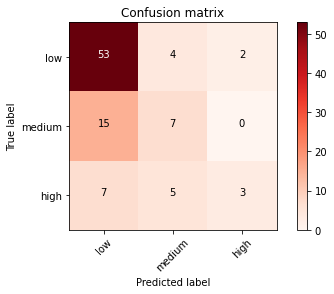

In [ ]:
result = model.predict_classes(padded_val)
print("all predicted result:", result)
cm = confusion_matrix(labels_val, result)
cm_plot_labels = ['low', 'medium', 'high']
plot_confusion_matrix(cm, cm_plot_labels)

#Test the model

single input  

In [ ]:
# input_text = "習慣了。現在漸漸地變成了一個常態只是後續要處理好自己還是人類部分的情感需求要漸漸地漸漸地習慣讓這部分死去直到我完全的成為了活屍我就成功了對她人最安全的做法就是我完全的不在對方的世界裏我也完全的不說話認識一個人。馬上把她刪好友是對對方最好的做法也是對我最好的做法沒有接觸。沒有期待 沒有傷害快樂是別人的 我什麼都沒有如果＊我＊的這概念也消失了那我就連這段話都感覺不到了這是我的目標成為一具屍體。也不知道賺錢做什麼我覺得世界是一座巨大的墳墓一切都在腐爛我是具有溫度的屍體感覺可以死了。可是又好像跟死了差不多說出這句話竟有種矛盾的感覺反正也離死不遠了--"
# ad_Class = 2
# ad_ID = 0
# ad_Description = input_text

# test_data_df = pd.DataFrame({'ID': [ad_ID], 
#                             'Description':[ad_Description],
#                             'Class':[ad_Class]})
# print(test_data_df)

multiple inputs

In [ ]:
#用記事本打開csv文件，另存為设置編碼為utf-8
test_data_source = "suicide2_test.csv"
test_data_df = pd.read_csv(data_dir + '/' + test_data_source, encoding='utf8', delimiter=',')
print(test_data_df.head())

In [ ]:
# 斷詞處理
test_df = JeibaCutWords(test_data_df, "Description")
print(test_df)
# 關鍵字檢查
#test_df['keyword_flag'], keywords_list = AppendKeywordCheck(test_df)

#extract all sentences
test_corpus = process_df(test_df)
print(f"total cases: {len(test_corpus)}")
print(test_corpus)

sentences_test=[]
labels_test=[]
for x in range(len(test_corpus)):
    sentences_test.append(test_corpus[x][0])
    labels_test.append(test_corpus[x][1])

print(f"test data: {len(sentences_test)}")

sequences_test = tokenizer.texts_to_sequences(sentences_test)
padded_test = pad_sequences(sequences_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)
#print(sequences_test)
#print(padded_test)

# probability = model.predict(padded_test)
# print(probability[0])
result = model.predict_classes(padded_test)
print(result)

In [ ]:
test_data_df['Predicted'] = result
test_data_df.to_csv(data_dir + '/suicide_test_result.csv', encoding='utf8')

In [ ]:
# if np.argmax(probability) == 2:
#   print("辨識結果: 高風險")
# elif np.argmax(probability) == 1:
#   print("辨識結果: 中風險")
# elif np.argmax(probability) == 0:
#   print("辨識結果: 低風險")

# print("判斷機率: ", probability[0][np.argmax(probability)])
# #print("違規字詞: ", keywords_list)

In [ ]:
cm = confusion_matrix(labels_test, result)
cm_plot_labels = ['low', 'medium', 'high']
plot_confusion_matrix(cm, cm_plot_labels)